# Testing Spark + `sparklyr` - part 2

## Table of Contents

- [Kickstart](#Kickstart)
- [R console](#Launch-R-console-first)
- [Jupyter](#Launch-Jupyter)
- [Uploading the data in JSON format](#Uploading-the-data-in-JSON-format)
- [Spark and R in Jupyter](#Spark-and-R-in-Jupyter)
- [Reading JSON into Spark context: `reviews_Books_5.json`](#Reading-JSON-into-Spark-context:-reviews_Books_5.json)
    - [Prepare dataset](#Prepare-dataset)
    - [Dichotomize & Tokenize](#Dichotomize-&-Tokenize)
- [Workaround: process `bin_reviews` in PySpark](#Workaround:-process-bin_reviews-in-PySpark)
- [Returning to `sparklyr`](#Returning-to-sparklyr)
- [Word counts](#Word-counts)
- [Graphs](#Graphs)
- [Model](#Model)
    - [Split Data](#Split-Data)
    - [Fit data](#Fit-data)
    - [Predict](#Predict)
- [Session](#Session)
    - [Paths recognised by R](#Paths-recognised-by-R)
    - [R session info](#R-session-info)
- [References](#References)

## Kickstart

Please, read the [pyspark course](https://github.com/javicacheiro/pyspark_course/blob/master/unit_1_tools.ipynb) here (points 1.1 to 1.3).

[Updated jul 2019]

Open a terminal

Connect to one of the login nodes of the Hadoop Hortonworks Data Platform (HDP) cluster (remember to activate Forticlient VPN first!):

    MY_CESGA_USER='abcdef' # my CESGA username 
    ssh $MY_CESGA_USER@hadoop3.cesga.es

In the new HDP server you have to load the Anaconda module that has the R distribution that works with Spark. 

This command needs to be executed everytime a new console is opened at CESGA:

    module load anaconda2  # run only once for every console 
    
To see the available modules type:
    
    module available # module av

## Launch R console first

#### <font color='#b3b3b3'>Configuring Spark and R kernel using .bashrc (currently not recommended)</font>

<br>
<font color='#b3b3b3'>
    
*We could add environment variables to .bashrc to avoid setting `Sys.setenv` in `R`.*

However, it is better to set `Sys.setenv()` as the **Anaconda version may change!** 


    cd $HOME
    export R_PROFILE_USER=/usr/hdp/2.4.2.0-258/spark/R/lib/SparkR/profile/shell.R
    # reload .bashrc
    source .bashrc
    


### Open R

Launch **R** (version 3.5.1 as of july 2019):

    R

### Install libraries in R

Install the libraries as needed. When you finish, exit the interactive `sparkR` session.

    > install.packages(c("sparklyr", "dplyr", "knitr", "repr", "tidytext", "tidyr", "purrr", "ggplot2", "viridis", "gridExtra", "rbokeh"))
    > q()

In [ ]:
Sys.getenv('R_PROFILE_USER')

## Launch Jupyter

To init a Jupyter notebook:

- Open a new console window.

- Connect to one of the login nodes of the Hadoop Hortonworks Data Platform (HDP) cluster: 

      ssh $MY_CESGA_USER@hadoop.cesga.es

- Load Anaconda2 distribution:

      module load anaconda2

- Launch the Jupyter notebook: 

      start_jupyter
    

- Follow the instructions in the console. You may be asked to paste an URL token into your browser. 

- Open the provided link in the browser

The notebook you have launched is tightly integrated with Spark in order to:

- Automatically opens a sparkR session with the cluster
- Dynamically expands the required executors in the cluster
- The console provides useful debugging information, showing Spark messages.

When you finish your interactive work remember to close the notebook properly:

- File -> Close and Halt


**Tip**: it is a good idea to leave two consoles open simultaneously, one for Jupyter (to open the notebook) and the other for Bash and sparkR commands.


## Uploading the data in JSON format 

First, we need to upload our data from our NFS **HOME** to the HDFS **HOME** directory.  
- You can add a single file, or an entire folder.
- You can also list or delete files, folders.

### HDFS overview and commands

See the [pyspark course](https://github.com/javicacheiro/pyspark_course/blob/master/unit_1_tools.ipynb) here (point 1.2) for HDFS basic commands.

Let's define some variables:

    # my username 
    MY_CESGA_USER='abcdef' 
    
    # my HDFS HOME 
    MY_HDFS_HOME=/user/$MY_CESGA_USER/    
    
    # my NFS HOME 
    MY_NFS_HOME=$HOME

HDFS basic commands:

    # import data into hdfs (jscars.json): 
    hdfs dfs -put $MY_NFS_HOME/Rsession/sparklyr_start/amazon/reviews_Books_5.json  # adapt to your path
    
    # list files 
    hdfs dfs -ls 
    # list files in a directory 
    hdfs dfs -ls $MY_HDFS_HOME
    # create a directory called 'data': 
    hdfs dfs -mkdir data 
    # delete a directory: 
    hdfs dfs -rm -r -f data
    # delete files, folders from hdfs
    hdfs dfs -rm -r -f amazon/reviews_Books_5.json

## Spark and R in Jupyter

### Configuring Spark and R 

Set `R` environment variables (needed for Jupyter notebooks in the cluster `R` installation).

In [11]:
# Sys.setenv(SPARK_HOME='/usr/hdp/2.4.2.0-258/spark/R/lib/SparkR/profile/shell.R') 
  # commented after being added to .bashrc
.libPaths(c(file.path(Sys.getenv('SPARK_HOME'), 'R', 'lib'), .libPaths()))

In [ ]:
Sys.getenv('SPARK_HOME')

Load libraries:

In [ ]:
options(warn = -1) # disable warnings

In [14]:
c("sparklyr", "dplyr", "knitr", "repr", "tidytext", "tidyr", "purrr", "ggplot2", "viridis", "gridExtra", "rbokeh")
lapply(x, require, character.only = TRUE, quietly = TRUE)

### Loading spark context - RDDs

Currently there are three types of contexts:

- Local context: 
    - Interactive. 
    - If the user exits session, the tasks are terminated (use `screen` to run after session close).
    - All processes reside in the LOGIN node (both drivers and executors).
    - Can only be used for tasks that require very few resources.
    - .Rmd notebook to run in your local computer
- YARN-client: 
    - Interactive.
    - If the user exits session, the tasks are terminated (use `screen` to run after session close).
    - The driver resides in the LOGIN node, but the executors are in the CLUSTER nodes. Thus, executors can use all the memory available for the task in the CLUSTER nodes.
    - Can be used for memory-intensive tasks.
- YARN-cluster:
    - Not interactive.
    - Both the driver and the executors reside in the CLUSTER nodes.
    - Can be used for memory-intensive tasks.
    - Currenty doesn't seem available for this version of `R/sparklyr`.
    
Defining a new context (`sc`) overwrites the previous one.

In [15]:
SPARK_HOME = Sys.getenv('SPARK_HOME')

In [ ]:
# Initiating spark context: local (for 'low memory' tasks only!)
# sc <- spark_connect(master = "local", spark_home = SPARK_HOME)

# Initiating spark context: yarn (for loading bigger datasets)
sc <- spark_connect(master = "yarn-client", spark_home = SPARK_HOME)
# sc <- spark_connect(master = "yarn-client", spark_home = "/usr/hdp/2.4.2.0-258/spark")

## Reading JSON into Spark context: `reviews_Books_5.json`

We will use a [dataset of Amazon Product Data](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz) [1] that contains 8.9M book reviews from Amazon, spanning May 1996 - July 2014.

Dataset characteristics:

- Number of reviews: 8.9M
- Size: 8.8GB (uncompressed)
- HDFS blocks: 70 (each with 3 replicas)

[1] Image-based recommendations on styles and substitutes J. McAuley, C. Targett, J. Shi, A. van den Hengel SIGIR, 2015 http://jmcauley.ucsd.edu/data/amazon/.  

I am translating into R the following tutorial: Sentiment analysis with Spark ML. [Material for Machine Learning Workshop Galicia 2016](http://nbviewer.jupyter.org/github/javicacheiro/machine_learning_galicia_2016/blob/master/notebooks/sentiment_analysis-amazon_books.ipynb).

In [17]:
books <- spark_read_json(sc, name = "books", path = "amazon/reviews_Books_5.json") 
# very big dataset

Here I used the Hive function `rpad` to truncate the variable `reviewText` to 30 characters. This allows for a correct display of the table.  
See more Hive functions in the [References](#References) section below. And also [this](http://www.folkstalk.com/2011/11/string-functions-in-hive.html):

In [18]:
books %>%
  mutate(reviewText_trunc = as.character(rpad(reviewText, 30, '...'))) %>%
  select(asin, helpful, overall, reviewText_trunc, reviewTime, reviewerID, reviewerName, summary, unixReviewTime) %>%
  head(3) %>%
  collect()

asin       helpful overall reviewText_trunc               reviewTime 
1 000100039X 0, 0    5       Spiritually and mentally inspi 12 16, 2012
2 000100039X 0, 2    5       This is one my must have books 12 11, 2003
3 000100039X 0, 0    5       This book provides a reflectio 01 18, 2014
  reviewerID            reviewerName                                   
1 A10000012B7CGYKOMPQ4L Adam                                           
2 A2S166WSCFIFP5        adead_poet@hotmail.com "adead_poet@hotmail.com"
3 A1BM81XB4QHOA3        Ahoro Blethends "Seriously"                    
  summary                         unixReviewTime
1 Wonderful!                      1355616000    
2 close to god                    1071100800    
3 Must Read for Life Afficianados 1390003200

In [19]:
# sdf_schema(books)
books %>%
  mutate(reviewText_trunc = as.character(rpad(reviewText, 20, '...'))) %>%
  select(reviewText, overall) %>% 
  sdf_schema() %>%
  print()

$reviewText
$reviewText$name
[1] "reviewText"

$reviewText$type
[1] "StringType"


$overall
$overall$name
[1] "overall"

$overall$type
[1] "DoubleType"




Summary of the counts for each review score:

In [11]:
books %>%
  count(overall, sort = TRUE) %>%
  collect() 

overall n      
1 5       4980815
2 4       2223094
3 3        955189
4 2        415110
5 1        323833

### Prepare dataset

We will avoid neutral reviews by keeping only reviews with 1 or 5 stars overall score. We will also filter out the reviews that contain no text.

In [20]:
reviews <- books %>%
  filter(overall == 1 | overall == 5) %>%
  filter(reviewText != '')

In [22]:
reviews %>%
  mutate(reviewText_trunc = as.character(rpad(reviewText, 30, '...'))) %>%
  select(overall, reviewText_trunc) %>%
  head(3) %>%
  collect()

overall reviewText_trunc              
1 5       Spiritually and mentally inspi
2 5       This is one my must have books
3 5       This book provides a reflectio

We will use `cache` when the lineage of your RDD branches out or when an RDD is used multiple times like in a loop

In [17]:
# tbl_cache(sc, reviews, force = TRUE)
## tbl_uncache(sc, books)

Total row count:

In [23]:
reviews %>%
  count() %>%
  collect()

n      
1 5304187

So far, so good.

### Dichotomize & Tokenize

We will convert the numerical covariate `overall` to binary (0/1) features ("binarize").   
Then we'll divide the reviews text into word-tokens ("tokenize").

In [21]:
bin_reviews <- reviews %>% 
  ft_binarizer(threshold = 2.5, input.col = 'overall', output.col = 'label') %>% 
  select(reviewText, overall, label)

In [22]:
tokenized_reviews <- bin_reviews %>% 
  ft_tokenizer(input.col = 'reviewText', output.col = 'word')

Visualize the resulting table and structure:

In [23]:
tokenized_reviews %>% 
  mutate(reviewText_trunc = as.character(rpad(reviewText, 20, '...'))) %>%
  select(reviewText_trunc, overall, label, word) %>% 
  head(1) %>%
  collect()

reviewText_trunc     overall label
1 Spiritually and ment 5       1    
  word                                                                                                                                                                                                                                                                                        
1 spiritually, and        , mentally   , inspiring! , a          , book       , that       , allows     , you        , to         , question   , your       , morals     , and        , will       , help       , you        , discover   , who        , you        , really     , are!

In [24]:
tokenized_reviews %>%
  mutate(reviewText_trunc = as.character(rpad(reviewText, 30, '...'))) %>%
  select(reviewText_trunc, overall, label, word) %>% 
  head(3) 

# Source:   lazy query [?? x 4]
# Database: spark_connection
                reviewText_trunc overall label        word
                           <chr>   <dbl> <dbl>      <list>
1 Spiritually and mentally inspi       5     1 <list [22]>
2 This is one my must have books       5     1 <list [49]>
3 This book provides a reflectio       5     1 <list [40]>

Here we see that the variable `word` is a **list-column**. To process it we would have to use [`tidyr::unnest`](https://www.rdocumentation.org/packages/tidyr/versions/0.6.3/topics/unnest).  
However, working with R methods such as `unnest` implies that the dataset must be downloaded to memory, which is unfeasible given its size.  
Unfortunately, as of today there's no method for unnesting in `sparklyr` (see [here](https://campus.datacamp.com/courses/introduction-to-spark-in-r-using-sparklyr/going-native-use-the-native-interface-to-manipulate-spark-dataframes?ex=6)). However it is listed as a [feature request](https://github.com/rstudio/sparklyr/issues/536) in GitHub.  
As an example, you can see what `unnest` can do in R: 

In [33]:
tokenized_reviews %>%
  select(word) %>%
  head(10) %>%
  collect() %>%
  mutate(word = lapply(word, as.character)) %>%
  unnest(word) %>% 
  head(5)

word       
1 spiritually
2 and        
3 mentally   
4 inspiring! 
5 a

## Workaround: process `bin_reviews` in PySpark

When a method is not present in `sparklyr`, the easiest solution is resorting to [**PySpark**](https://spark.apache.org/docs/0.9.0/python-programming-guide.html), which exposes the Spark (Scala) programming model to Python.  
A great tutorial to start is this [PySpark Course](https://github.com/javicacheiro/pyspark_course), by @javicacheiro.  
We will start feeding some data to PySpark, so first we must save our dataset `bin_reviews` in HDFS:

In [12]:
spark_write_json(bin_reviews, "amazon/bin_reviews.json", mode = NULL, options = list())

Just to be sure, we can check if the database has been saved:

    $ hdfs dfs -ls amazon

Follow the PySpark transformations to the data, in the notebook [sparklyr_python.ipynb](./sparklyr_python.ipynb): 
- In PySpark, we will tokenize our `words` variable.  
- We will remove the stop words.
- We will 'flatten' or 'explode' our `words` column to have each word in its own row.
- Then, we'll reload the transformed dataset! (Thanks, pySpark!)

## Returning to `sparklyr`

Import the transformed data into `sparklyr` again: 

In [101]:
options(repr.plot.width=12, repr.plot.height=5)

In [25]:
unnested_reviews <- spark_read_json(sc, name = "unnested_reviews_json", path = "amazon/unnested_reviews_json") %>%
  filter(length(word) > 2) %>%
  mutate(word2 = regexp_replace(word, "[^a-zA-Z0-9]+", "")) %>% 
  group_by(label) %>% 
  count(word2, sort = TRUE) 

Note the **Hive/PostgreSQL** function [`regexp_replace`](https://www.postgresql.org/docs/9.4/static/functions-matching.html#FUNCTIONS-POSIX-REGEXP) used to remove punctuation and special marks.

## Word counts

Positive reviews:

In [26]:
positive_reviews <- unnested_reviews %>% 
  filter(label=="1") %>%
  arrange(desc(n)) %>% 
  head(10) %>% 
  collect()

Negative reviews:

In [27]:
negative_reviews <- unnested_reviews %>% 
  filter(label=="0") %>%
  arrange(desc(n)) %>% 
  head(10) %>% 
  collect()

In [193]:
total_reviews <- positive_reviews %>%
  bind_rows(negative_reviews) %>%
  arrange(desc(n))

## Graphs

### Using **ggplot2**:

In [196]:
total_reviews$label <- factor(total_reviews$label, labels = c("negative", "positive"))

g <- total_reviews %>% 
    ggplot(aes(x=reorder(word2, -n))) +
    xlab("words in reviews") + ylab("count") + 
    theme_bw()

Printing **ggplot2** plots:

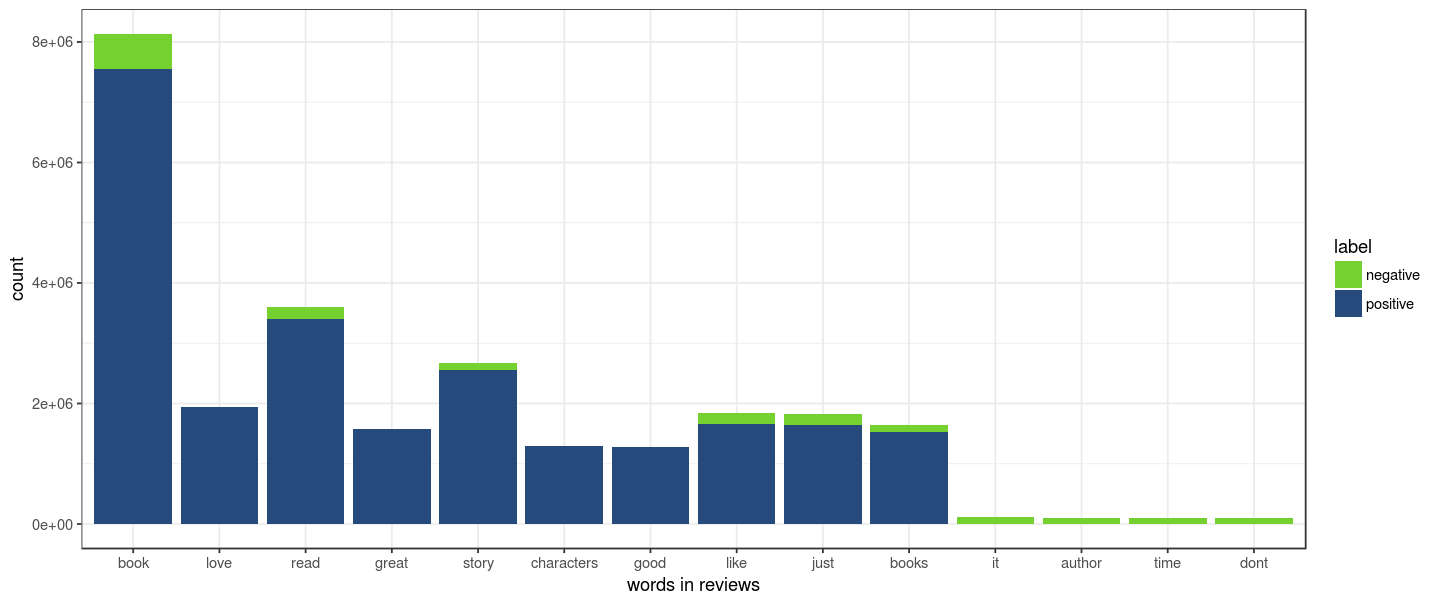

In [197]:
g + 
  geom_col(aes(y=n, fill = label)) + 
  scale_fill_manual(values=c("#74d130", "#274a7c"))

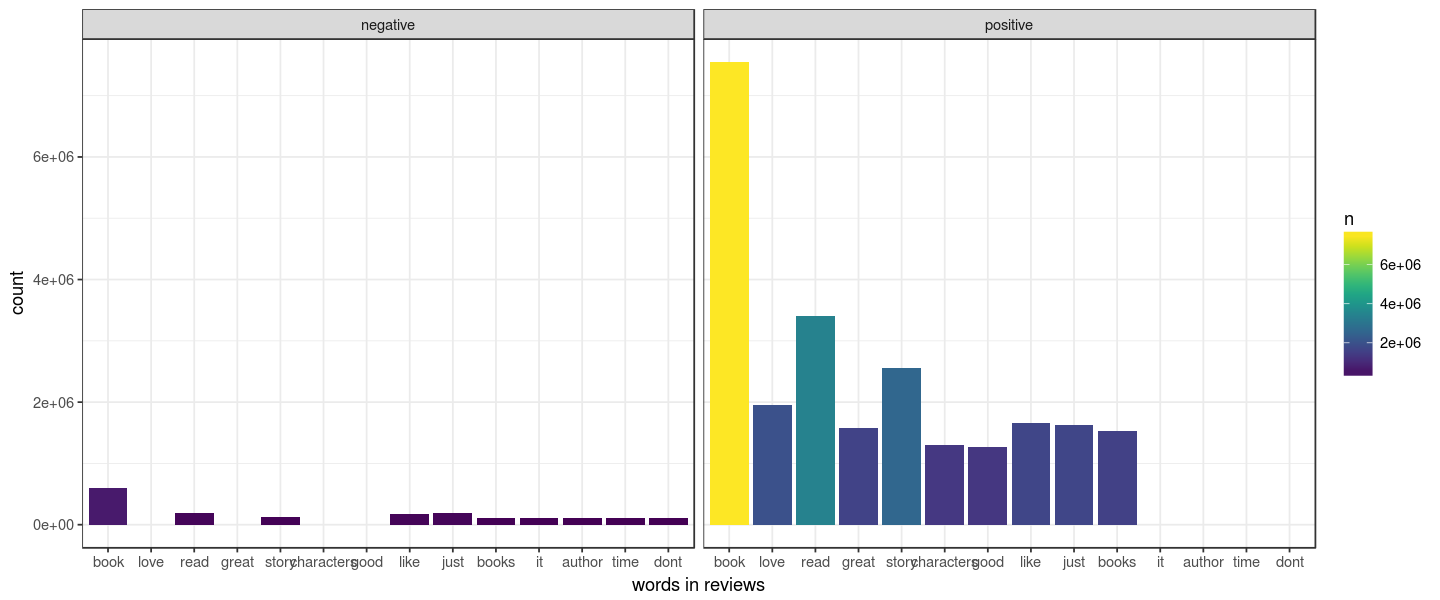

In [198]:
g + 
  geom_col(aes(y=n, fill = n)) + 
  scale_fill_viridis() +
  facet_grid(. ~ label)

### Using **bokeh**:

In [28]:
p1 <- positive_reviews %>% 
  figure() %>% 
    ly_bar(x = word2, y = n,
           hover = TRUE, color = NULL) %>%
    x_axis(label = "positive words") %>%
    y_axis(label = "count") 

In [29]:
p2 <- negative_reviews %>% 
  figure() %>% 
    ly_bar(x = word2, y = n,
           hover = TRUE) %>%
    x_axis(label = "negative words") %>%
    y_axis(label = "count")

Printing **bokeh** plots:

In [30]:
grid_plot(list(p2, p1), same_axes = TRUE, width=900, height=350)

HTML widgets cannot be represented in plain text (need html)

## Model

### Split Data

Split data into training and evaluation data for our model:

In [52]:
partitions <- unnested_reviews %>%
  sdf_partition(trainingData = 0.8, testData = 0.2)

In [55]:
partitions$trainingData %>% 
  head(3) %>%
  collect

label word   n  
1 0     "and   600
2 0     "book" 737
3 0     "for   619

In [56]:
partitions$testData %>%
  head(3) %>%
  collect()

label word n   
1 0     "all  644
2 0     "he   970
3 0     "if  1209

## Session 

### Paths recognised by R 

In [29]:
.libPaths()
Sys.getenv("R_HOME")

### R session info

In [202]:
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

locale:
 [1] LC_CTYPE=es_ES.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=es_ES.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=es_ES.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] gridExtra_2.2.1   viridis_0.4.0     viridisLite_0.2.0 bindrcpp_0.2     
 [5] rbokeh_0.5.0      purrr_0.2.2.2     tidyr_0.6.0       tidytext_0.1.3   
 [9] repr_0.10         ggplot2_2.2.1     knitr_1.15.1      dplyr_0.7.1      
[13] sparklyr_0.5.6    SparkR_1.6.1     

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.8        lattice_0.20-34    assertthat_0.1     rprojroot_1.1     
 [5] diges

## References 

- [`sparklyr` presentation](https://cdn.oreillystatic.com/en/assets/1/event/193/Sparklyr_%20An%20R%20interface%20for%20Apache%20Spark%20Presentation.pdf)
- [`sparklyr` tutorial](http://spark.rstudio.com/).
- [`sparklyr` cheatsheet](http://spark.rstudio.com/images/sparklyr-cheatsheet.pdf).
- [`sparklyr`: creating extensions](http://spark.rstudio.com/extensions.html).
- [Differences between `sparkr` and `sparklyr`](https://stackoverflow.com/questions/39494484/sparkr-vs-sparklyr).
- [Hive Operators and UDFs](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF).
- [String Functions in Hive](http://www.folkstalk.com/2011/11/string-functions-in-hive.html).
- [POSIX regular expressions](https://www.postgresql.org/docs/9.4/static/functions-matching.html#FUNCTIONS-POSIX-REGEXP).
- [Material for Machine Learning Workshop Galicia 2016](http://nbviewer.jupyter.org/github/javicacheiro/machine_learning_galicia_2016/blob/master/notebooks/sentiment_analysis-amazon_books.ipynb).
- [PySpark Course](https://github.com/javicacheiro/pyspark_course).